# Requirements

* Python 3.6: Ensure Python 3.6 is installed and accessible (e.g., via the py -3.6 command).
* backcall: backcall-0.2.0-py2.py3-none-any.whl
* certifi: certifi-2021.5.30-py2.py3-none-any.whl
* charset_normalizer: charset_normalizer-2.0.0-py3-none-any.whl
* colorama: colorama-0.4.4-py2.py3-none-any.whl
* cycler: cycler-0.10.0-py2.py3-none-any.whl
* decorator: decorator-4.4.2-py2.py3-none-any.whl
* flatbuffers: flatbuffers-1.12-py2.py3-none-any.whl
* google_auth_oauthlib: google_auth_oauthlib-0.4.1-py2.py3-none-any.whl
* google_pasta: google_pasta-0.2.0-py3-none-any.whl
* grpcio: grpcio-1.37.0-cp36-cp36m-win_amd64.whl
* ipykernel: ipykernel-5.5.6-py3-none-any.whl
* ipython: ipython-7.16.3-py3-none-any.whl
* ipython_genutils: ipython_genutils-0.2.0-py2.py3-none-any.whl
* jedi: jedi-0.17.2-py2.py3-none-any.whl
* jupyter_client: jupyter_client-6.1.12-py3-none-any.whl
* jupyter_core: jupyter_core-4.7.1-py3-none-any.whl
* keras: keras-2.6.0-py2.py3-none-any.whl
* Keras_Preprocessing: Keras_Preprocessing-1.1.2-py2.py3-none-any.whl
* kiwisolver: kiwisolver-1.3.1-cp36-cp36m-win_amd64.whl
* matplotlib: matplotlib-3.3.4-cp36-cp36m-win_amd64.whl
* numpy: numpy-1.19.5-cp36-cp36m-win_amd64.whl
* oauthlib: oauthlib-3.1.0-py2.py3-none-any.whl
* opt_einsum: opt_einsum-3.3.0-py3-none-any.whl
* parso: parso-0.7.1-py2.py3-none-any.whl
* pickleshare: pickleshare-0.7.5-py2.py3-none-any.whl
* Pillow: Pillow-8.4.0-cp36-cp36m-win_amd64.whl
* prompt_toolkit: prompt_toolkit-2.0.10-py3-none-any.whl
* protobuf: protobuf-3.17.3-cp36-cp36m-win_amd64.whl
* Pygments: Pygments-2.6.1-py3-none-any.whl
* pyparsing: pyparsing-2.4.7-py2.py3-none-any.whl
* python_dateutil: python_dateutil-2.8.1-py2.py3-none-any.whl
* pywin32: pywin32-228-cp36-cp36m-win_amd64.whl
* pyzmq: pyzmq-19.0.2-cp36-cp36m-win_amd64.whl
* requests: requests-2.26.0-py2.py3-none-any.whl
* requests_oauthlib: requests_oauthlib-1.3.0-py2.py3-none-any.whl
* scipy: scipy-1.5.4-cp36-cp36m-win_amd64.whl
* six: six-1.15.0-py2.py3-none-any.whl
* tensorboard: tensorboard-2.6.0-py3-none-any.whl
* tensorflow: tensorflow-2.6.0-cp36-cp36m-win_amd64.whl
* termcolor: Both termcolor-1.1.0 (package) and termcolor-1.1.0.tar.gz
* tornado: tornado-6.1-cp36-cp36m-win_amd64.whl
* traitlets: traitlets-4.3.3-py2.py3-none-any.whl
* typing_extensions: typing_extensions-3.7.4.3-py3-none-any.whl
* wcwidth: wcwidth-0.2.5-py2.py3-none-any.whl
* wrapt: Both wrapt-1.12.1 (package) and wrapt-1.12.1.tar.gz


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
import keras as k

from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

In [2]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50 # number of epochs
epsilon_std = 1.0
import tensorflow._api.v2.compat.v1 as tf

tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [4]:
# input to our encoder
x = Input(shape=(original_dim,), name="input")
# intermediate layer
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
# defining the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)
# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoding (Dense)                (None, 256)          200960      input[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            514         encoding[0][0]                   
__________________________________________________________________________________________________
log-variance (Dense)            (None, 2)            514         encoding[0][0]                   
____________________________________________________________________________________________

In [5]:
# Input to the decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_h (Dense)            (None, 256)               768       
_________________________________________________________________
flat_decoded (Dense)         (None, 784)               201488    
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [6]:
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [7]:
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,
            z_log_var=z_log_var, z_mean=z_mean,
            original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(
        1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Functional)         (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [9]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 42us/sample - loss: 190.1700
Epoch 2/50
60000/60000 [==============================] - 2s 34us/sample - loss: 169.7760
Epoch 3/50
60000/60000 [==============================] - 2s 35us/sample - loss: 166.2688
Epoch 4/50
60000/60000 [==============================] - 2s 35us/sample - loss: 164.1698
Epoch 5/50
60000/60000 [==============================] - 2s 34us/sample - loss: 162.8031
Epoch 6/50
60000/60000 [==============================] - 2s 35us/sample - loss: 161.6592
Epoch 7/50
60000/60000 [==============================] - 2s 35us/sample - loss: 160.6927
Epoch 8/50
60000/60000 [==============================] - 2s 36us/sample - loss: 159.7914
Epoch 9/50
60000/60000 [==============================] - 2s 37us/sample - loss: 158.9350
Epoch 10/50
60000/60000 [==============================] - 2s 35us/sample - loss: 158.1423
Epoch 11/50
60000/60000 [==============================] - 2s 36us/sample - 

e:\projects\pfransozi.github\gans-in-action\.venv\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


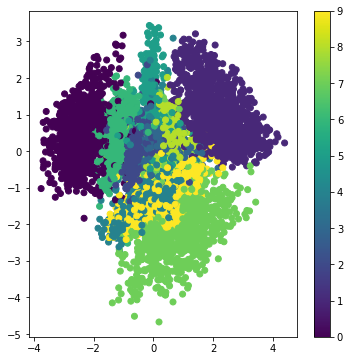

In [10]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

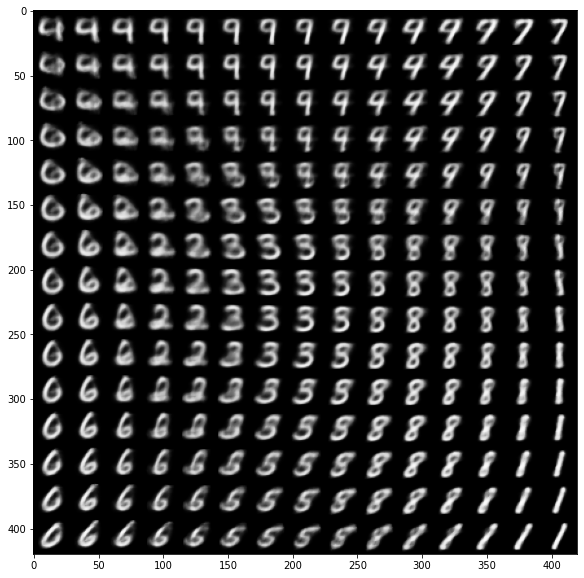

In [17]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()